# Продвинутый SQL
ER-диаграмма базы данных: https://code.s3.yandex.net/SQL%20for%20data%20and%20analytics/ER/advanced_sql_project.pdf
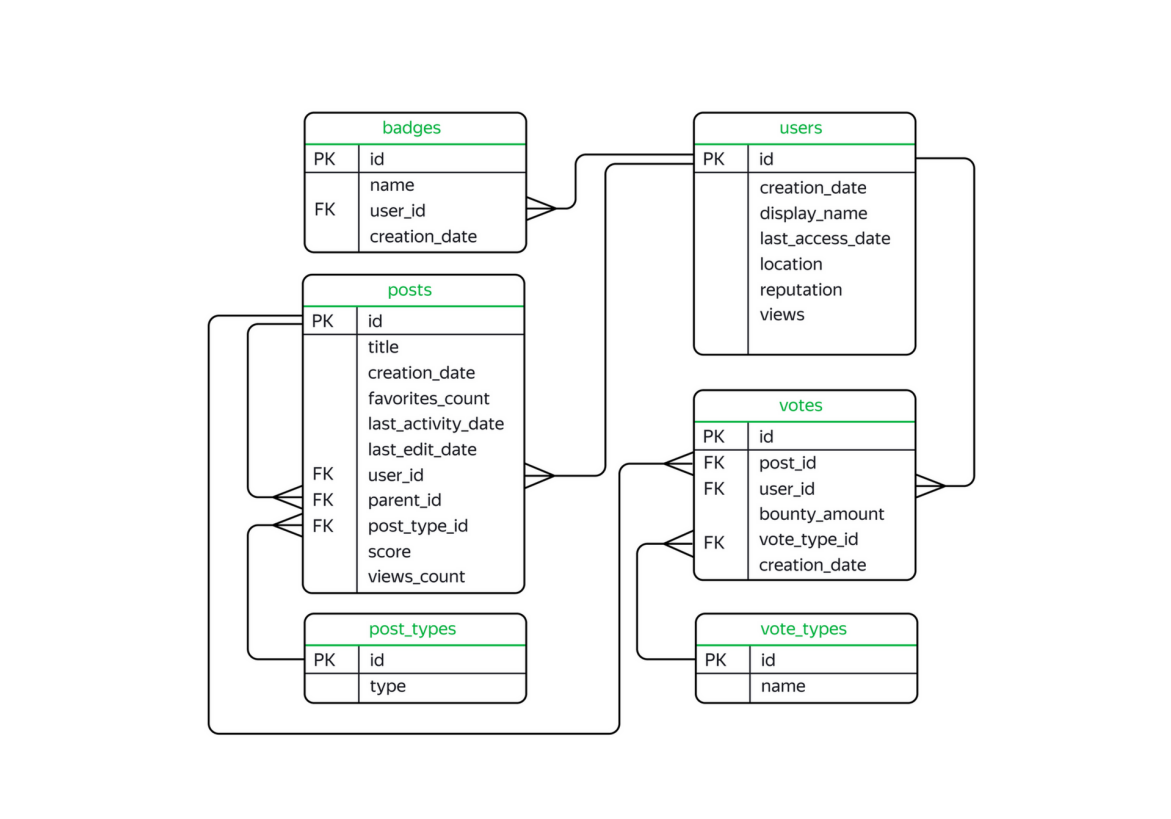

## Задания (Первая часть)

### Задание 1. Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

```
SELECT COUNT(id)
FROM stackoverflow.posts
WHERE post_type_id=1 
   AND (score>300 OR favorites_count >= 100)
GROUP BY post_type_id;
```

### Задание 2. Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

```
    SELECT ROUND(AVG(t.count),0)
FROM (
      SELECT COUNT(id),
             creation_date::date
      FROM stackoverflow.posts
      WHERE post_type_id = 1
      GROUP BY creation_date::date
      HAVING creation_date::date BETWEEN '2008-11-01' AND '2008-11-18') AS t; ```

### Задание 3. Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

```
SELECT COUNT(DISTINCT u.id)
FROM stackoverflow.badges AS b
JOIN stackoverflow.users AS u ON b.user_id=u.id
WHERE b.creation_date::date = u.creation_date::date;
```

### Задание 4. Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

```
SELECT COUNT(t.id)
FROM (
     SELECT p.id
     FROM stackoverflow.posts AS p
     JOIN stackoverflow.votes AS v ON p.id = v.post_id
     JOIN stackoverflow.users AS u ON p.user_id = u.id
     WHERE u.display_name LIKE 'Joel Coehoorn'
     GROUP BY p.id
     HAVING COUNT(v.id)>=1) as t;
```

### Задание 5. Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

```
SELECT *,
       ROW_NUMBER() OVER(ORDER BY id DESC) AS rank
FROM stackoverflow.vote_types
ORDER BY id;
```

### Задание 6. Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

```
SELECT *
FROM (
      SELECT v.user_id,
             COUNT(vt.id) AS cnt
      FROM stackoverflow.votes AS v
      JOIN stackoverflow.vote_types as vt ON vt.id = v.vote_type_id
      WHERE vt.name LIKE 'Close'
      GROUP BY v.user_id
      ORDER BY cnt DESC LIMIT 10
    ) AS t
ORDER BY t.cnt DESC, t.user_id DESC;
```

### Задание 7. Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.
+ Отобразите несколько полей:
+ идентификатор пользователя;
+ число значков;
место в рейтинге — чем больше значков, тем выше рейтинг.
Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя..

```
SELECT *,
      DENSE_RANK() OVER (ORDER BY t.cnt DESC) AS n
FROM (SELECT COUNT(id) AS  cnt,
             user_id
      FROM stackoverflow.badges
      WHERE creation_date::date BETWEEN '2008-11-15' AND '2008-12-15' 
      GROUP BY 2
      ORDER BY cnt DESC, user_id LIMIT 10) as t;

```

### Задание 8. Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:\
+ заголовок поста;
+ идентификатор пользователя;
+ число очков поста;
+ среднее число очков пользователя за пост, округлённое до целого числа.
Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

```
WITH t AS (
SELECT ROUND(AVG(score)) AS avg_score,
       user_id
FROM stackoverflow.posts
WHERE title IS NOT NULL 
   AND score <> 0
GROUP BY user_id
)

SELECT p.title,
       t.user_id,
       p.score,
       t.avg_score
FROM t 
JOIN stackoverflow.posts AS p ON t.user_id=p.user_id
WHERE p.title IS NOT NULL 
   AND p.score <> 0;   
```

### Задание 9. Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

```
SELECT title
FROM stackoverflow.posts
WHERE user_id IN (
                  SELECT user_id
                  FROM stackoverflow.badges
                  GROUP BY user_id
                  HAVING COUNT(id) >1000
                  )
  AND title IS NOT NULL;
```

### Задание 10. Напишите запрос, который выгрузит данные о пользователях из Канады (англ. Canada). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
+ пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
+ пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
+ пользователям с числом просмотров меньше 100 — группу 3.\
Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с количеством просмотров меньше либо равным нулю не должны войти в итоговую таблицу.

```
SELECT id,
       views,
       CASE
          WHEN views >= 350 THEN 1
          WHEN views < 100 THEN 3
          ELSE 2
       END AS group
FROM stackoverflow.users
WHERE location LIKE '%Canada%' AND views > 0;
```

### Задание 11. Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

```
WITH grp AS (SELECT g.id,
                    g.views,
                    g.group,
                    MAX(g.views) OVER (PARTITION BY g.group) AS max     
             FROM (SELECT id,
                          views,
                          CASE
                             WHEN views >= 350 THEN 1
                             WHEN views < 100 THEN 3
                             ELSE 2
                          END AS group
                   FROM stackoverflow.users
                   WHERE location LIKE '%Canada%' AND views > 0) as g
              )
  
SELECT grp.id, 
       grp.views,  
       grp.group
FROM grp
WHERE grp.views = grp.max
ORDER BY grp.views DESC, grp.id;

```

### Задание 12. Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
+ номер дня;
+ число пользователей, зарегистрированных в этот день;
+ сумму пользователей с накоплением.

```
SELECT *,
       SUM(uc.cnt_reg) OVER (ORDER BY uc.days) as cnt_users
FROM (SELECT EXTRACT(DAY FROM creation_date::date) AS days,
             COUNT(id) AS cnt_reg
      FROM stackoverflow.users
      WHERE creation_date::date BETWEEN '2008-11-01' AND '2008-11-30'
      GROUP BY EXTRACT(DAY FROM creation_date::date)
      ) as uc;
```

### Задание 13. Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
+ идентификатор пользователя;
+ разницу во времени между регистрацией и первым постом.

```
WITH dt AS (SELECT DISTINCT user_id,
                            MIN(creation_date) OVER (PARTITION BY user_id) AS min_dt      
            FROM stackoverflow.posts)

SELECT dt.user_id,
       (dt.min_dt - u.creation_date) AS diff
FROM stackoverflow.users AS u 
JOIN dt ON  u.id = dt.user_id;
```

## Задания (Вторая часть)

### Задание 1. Выведите общую сумму просмотров у постов, опубликованных в каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

```
SELECT DATE_TRUNC('month', creation_date)::date AS mnth,
       SUM(views_count) 
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY SUM(views_count) DESC;
```

### Задание 2. Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. Отсортируйте результат по полю с именами в лексикографическом порядке.

```
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u ON p.user_id=u.id
JOIN stackoverflow.post_types AS pt ON pt.id=p.post_type_id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month') 
      AND pt.type LIKE '%Answer%'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name;
```

### Задание 3. Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

```
WITH users AS (SELECT u.id
               FROM stackoverflow.posts AS p
               JOIN stackoverflow.users AS u ON p.user_id=u.id
               WHERE DATE_TRUNC('month', u.creation_date)::date = '2008-09-01' 
                   AND DATE_TRUNC('month', p.creation_date)::date = '2008-12-01'
               GROUP BY u.id
               HAVING COUNT(p.id) > 0)

SELECT COUNT(p.id),
       DATE_TRUNC('month', p.creation_date)::date
FROM stackoverflow.posts AS p
WHERE p.user_id IN (SELECT *
                    FROM users)
      AND DATE_TRUNC('year', p.creation_date)::date = '2008-01-01'
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC;
```

### Задание 4. Используя данные о постах, выведите несколько полей:
+ идентификатор пользователя, который написал пост;
+ дата создания поста;
+ количество просмотров у текущего поста;\
сумма просмотров постов автора с накоплением.
Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

```
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts;
```

### Задание 5. Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.


```
WITH ad AS (SELECT user_id,
                   COUNT(DISTINCT creation_date::date)  AS cnt
            FROM stackoverflow.posts
            WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07' 
            GROUP BY user_id)

SELECT ROUND(AVG(ad.cnt))
FROM ad
```

### Задание 6. На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:
+ Номер месяца.
+ Количество постов за месяц.
+ Процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.\
Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.
Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип numeric.

```
WITH month_post AS (SELECT EXTRACT(MONTH from creation_date::date) AS month,
                    COUNT(DISTINCT id)    
                    FROM stackoverflow.posts
                    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
                    GROUP BY month)

SELECT *,
       ROUND(((count::numeric / LAG(count) OVER (ORDER BY month)) - 1) * 100, 2) AS user_growth
FROM month_post
```

### Задание 7. Найдите пользователя, который опубликовал больше всего постов за всё время с момента регистрации. Выведите данные его активности за октябрь 2008 года в таком виде:
+ номер недели;
+ дата и время последнего поста, опубликованного на этой неделе.

```
WITH user_post AS (SELECT user_id,
                   COUNT(DISTINCT id) AS cnt
                   FROM stackoverflow.posts
                   GROUP BY user_id
                   ORDER BY cnt DESC
                   LIMIT 1),

     dtt AS (SELECT p.user_id,
             p.creation_date,
             extract('week' from p.creation_date) AS week_number
             FROM stackoverflow.posts AS p
             JOIN user_post ON user_post.user_id = p.user_id
             WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-10-01')

SELECT DISTINCT week_number::numeric,
       MAX(creation_date) OVER (PARTITION BY week_number) AS post_dt
FROM dtt
ORDER BY week_number;
```